In [1]:
import sys
try:
    from google.colab import drive
    drive.mount("/content/drive")
    main_path = '/content/drive/My Drive/lee_mcc9/'
except:
    main_path = ''
sys.path.append(main_path)

In [2]:
import uproot
import numpy as np
import math
import matplotlib.pyplot as plt

fold = "nuselection"
tree = "NeutrinoSelectionFilter"

variables = [
    "shr_dedx_Y", "shr_bkt_pdg", "p", "pt", "selected", "nu_pdg", "shr_theta",
    "slpdg", "trk_score_v", "shr_theta_v", "shr_score_v",
    "shr_pfp_id_v", "category", "shr_tkfit_dedx_Y", "trk_pfp_id",
    "shr_energy_tot", "trk_energy_tot", "shr_hits_tot", "ccnc", "trk_chipr",
    "trk_bkt_pdg", "hits_ratio", "n_tracks_contained", "shr_dedx_y_v",
    "nproton", "nu_e", "n_showers_contained", "shr_distance", "trk_distance",
    "hits_y", "shr_pz", "shr_energy", "shr_dedx_U", "shr_dedx_V", "shr_phi", "trk_phi", "trk_theta",
    "shr_tkfit_dedx_U", "shr_tkfit_dedx_V", "run", "sub", "evt", "nproton", "trk_pid_chipr_v",
    "trk_len", "slnunhits", "slnhits", "shr_score", "trk_score", "trk_hits_tot",
    "true_e_visible", "matched_E", "shr_bkt_E", "trk_bkt_E", "trk_energy", "tksh_distance", "tksh_angle",
    "trk_chipr_best", "trk_chipr_worst", "trk_pida", "trk_chimu", "CosmicIP", "trk_bragg_p", "trk_bragg_mu",
    "trk_bragg_mip", "shr_chipr", "shr_bragg_p", "shr_bragg_mu", "shr_chimu",
    "shr_pca_2", "shr_pca_0", "shr_pca_1", "npi0", "gamma1_edep", "gamma2_edep", "topological_score",
    "pi0_e", "shr_energy_tot_cali", "shr_dedx_Y_cali", "evnunhits", "nslice", "weightSpline" #, "crtveto", "crthitpe",
#    "_closestNuCosmicDist"
]

weights = {
    "mc": 0.040061,
    "nue": 0.0004442,
}

mc_det = {
    "cv": uproot.open(main_path+"root_files/det_sys/prodgenie_bnb_nu_uboone_overlay_det_var_run1_mcc9.1_cv_reco2.root")[fold][tree].pandas.df(variables, flatten=False),
    "dlup": uproot.open(main_path+"root_files/det_sys/prodgenie_bnb_nu_uboone_overlay_det_var_run1_mcc9.1_dlup_reco2.root")[fold][tree].pandas.df(variables, flatten=False)
}

nue_det = {
    "cv": uproot.open(main_path+"root_files/det_sys/prodgenie_bnb_intrinsic_nue_uboone_overlay_detvar_mcc9.1_run1_CV_reco2.root")[fold][tree].pandas.df(variables, flatten=False),
    "dlup": uproot.open(main_path+"root_files/det_sys/prodgenie_bnb_intrinsic_nue_uboone_overlay_detvar_mcc9.1_run1_DLup_reco2.root")[fold][tree].pandas.df(variables, flatten=False)
}

mc_weight = {
    "cv": 4.5e19/1.13302e+20,
    "dlup": 4.5e19/1.14551e+20
}

nue_weight = {
    "cv": 4.5e19/2.55306e+22,
    "dlup": 4.5e19/2.46239e+22
}

[0.09205744 0.03151802 0.15164212 0.02018007 0.06637916 0.06855351
 0.07694425 0.07276595 0.0063131  0.03030477 0.02135144 0.09169938
 0.06840748 0.05409349 0.08051799 0.13666272 0.08099508 0.04661208
 0.24508419 0.18729581]


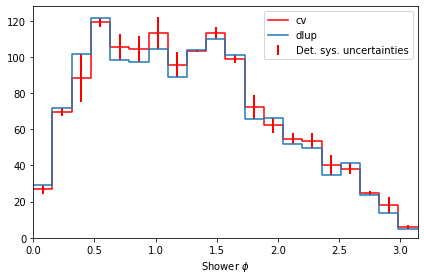

In [45]:
x_range = 0,math.pi
n_bins = 20
var_name = "shr_theta"
n_tot = {}

for det in mc_det:
    mc_det[det]["reco_e"] = (mc_det[det]["shr_energy_tot_cali"] + 0.030) / 0.79 + mc_det[det]["trk_energy_tot"]
    nue_det[det]["reco_e"] = (nue_det[det]["shr_energy_tot_cali"] + 0.030) / 0.79 + nue_det[det]["trk_energy_tot"]

    mc_tree = mc_det[det]

    mc_queried_tree = mc_tree.query("selected==1 & nu_pdg != 12")
    mc_variable = mc_queried_tree[var_name]
    mc_spline_fix = mc_queried_tree["weightSpline"]*mc_weight[det]

    n_mc, bins = np.histogram(
        mc_variable,
        range=x_range,
        bins=n_bins,
        weights=mc_spline_fix
    )
    
    nue_tree = nue_det[det]

    nue_queried_tree = nue_tree.query("selected==1")
    nue_variable = nue_queried_tree[var_name]
    nue_spline_fix = nue_queried_tree["weightSpline"]*nue_weight[det]

    n_nue, bins = np.histogram(
        nue_variable,
        range=x_range,
        bins=n_bins,
        weights=nue_spline_fix
    )
    
    n_tot[det] = n_nue + n_mc  

cov = np.empty([len(n_tot["cv"]), len(n_tot["cv"])])
cov.fill(0)

for det in mc_det:
    if det == "cv":
        continue
    for i in range(len(n_tot["cv"])):
        for j in range(len(n_tot["cv"])):
            cov[i][j] += (n_tot[det][i] - n_tot["cv"][i])*(n_tot[det][j] - n_tot["cv"][j])

frac_cov = np.empty([len(n_tot["cv"]), len(n_tot["cv"])])
corr = np.empty([len(n_tot["cv"]), len(n_tot["cv"])])

for i in range(len(n_tot["cv"])):
    for j in range(len(n_tot["cv"])):
        frac_cov[i][j] = cov[i][j] / (n_tot["cv"][i] * n_tot["cv"][j])
        corr[i][j] = cov[i][j] / np.sqrt(cov[i][i] * cov[j][j])
            
for det in n_tot:
    left,right = bins[:-1],bins[1:]
    X = np.array([left,right]).T.flatten()
    Y = np.array([n_tot[det],n_tot[det]]).T.flatten()
    if det == "cv":
        plt.plot(X,Y,label=det, color="r")
    else:
        plt.plot(X,Y,label=det)
        
bincenters = 0.5 * (bins[1:] + bins[:-1])
    
plt.errorbar(
    bincenters, 
    n_tot["cv"],
    yerr=np.sqrt(np.diag(cov)), 
    fmt='none', 
    ecolor='r',
    linewidth=2,
    label='Det. sys. uncertainties')
    
print(np.sqrt(np.diag(cov))/n_tot["cv"])
    
plt.xlabel(r"Shower $\phi$")
plt.xlim(x_range[0],x_range[1])
plt.ylim(ymin=0)
plt.legend()
plt.tight_layout()
plt.savefig("plots/det.pdf")

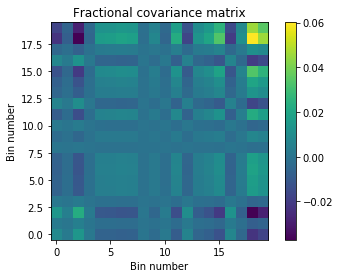

In [41]:
fig, ax = plt.subplots(1, 1)
pos = ax.imshow(frac_cov, origin='lower', cmap='viridis')
ax.set_title("Fractional covariance matrix")
ax.set_ylabel("Bin number")
ax.set_xlabel("Bin number")
fig.colorbar(pos)

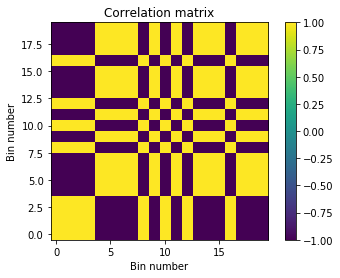

In [42]:
fig, ax = plt.subplots(1, 1)
ax.set_title("Correlation matrix")
pos = ax.imshow(corr, origin='lower')
ax.set_ylabel("Bin number")
ax.set_xlabel("Bin number")
fig.colorbar(pos)